# **Parameter Optimisation for GITT** 

This notebook is created to provide an example for ```GITT``` optimisation problem. Diffisuion Coefficient is optimised in this notebook. Only voltage will be considered for optimisation in this example.
 The workflow is as follows:


In [1]:
#%pip install git+https://github.com/paramm-team/pybamm-param.git -q
import pybamm
import pbparam
import pandas as pd
#from src import segment
import os
#import src

folder_path = (os.path.join(pbparam.__path__[0], "input", "data/GITT"))

# Get a list of all files in the folder
all_files = os.listdir(folder_path)

# Filter the list to get only .csv files
csv_files = [file for file in all_files if file.endswith('.csv')]

In [2]:
# Extract pulse numbers from filenames and sort them
pulse_numbers = [int(file_name.split('_')[1].split('.csv')[0]) for file_name in csv_files]
sorted_files_by_pulse = [f"pulse_{num}.csv" for num in sorted(pulse_numbers)]

# Loop through each CSV file and read it into a DataFrame
dfs = {}  # Store each DataFrame in a dictionary with the filename as the key

for csv_file in sorted_files_by_pulse:
    file_path = os.path.join(folder_path, csv_file)
    dfs[csv_file] = pd.read_csv(file_path)

In [3]:
dfs["pulse_1.csv"]["Positive electrode potential [V]"] + dfs["pulse_1.csv"]["Negative electrode potential [V]"] - dfs["pulse_1.csv"]["Voltage [V]"]

0     -0.0103
1      0.1286
2     -0.0088
3     -0.0094
4     -0.0099
        ...  
270   -0.0099
271   -0.0104
272   -0.0102
273   -0.0106
274   -0.0102
Length: 275, dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


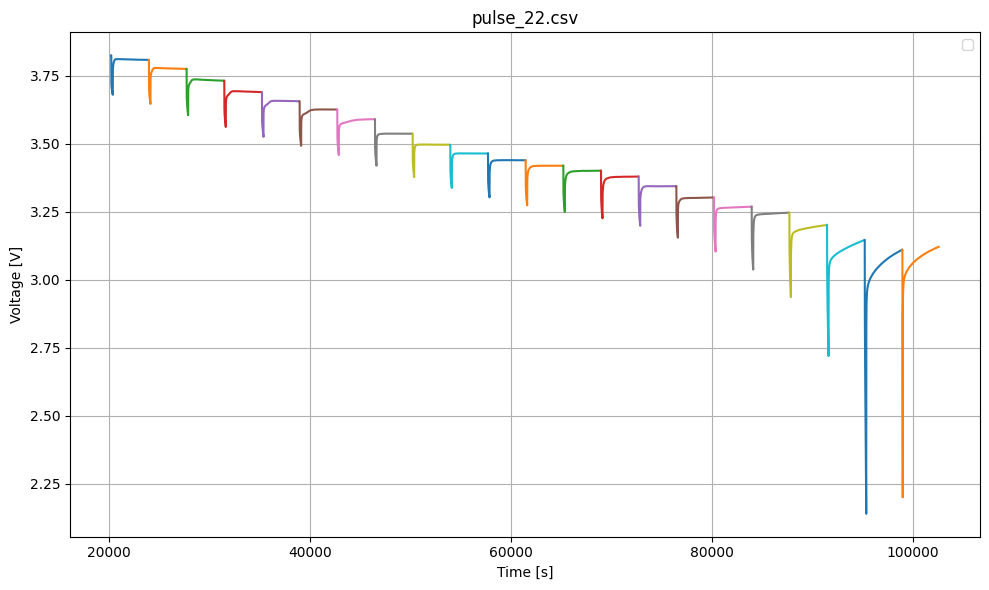

In [4]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))
for file_name, df in dfs.items():
    plt.title(file_name)
    ax.plot(df['Time [s]'], df["Positive electrode potential [V]"])
ax.set_xlabel('Time [s]')
ax.set_ylabel('Voltage [V]')
ax.legend(loc='best')
ax.grid(True)
plt.tight_layout()
plt.show()

[4.0896, 4.0729, 4.0362, 3.9893, 3.9464, 3.9109, 3.8767, 3.836, 3.7723, 3.7241, 3.686, 3.6565, 3.6327, 3.6107, 3.5853, 3.5438, 3.494, 3.4488, 3.4148, 3.3393, 3.2096, 3.0535]


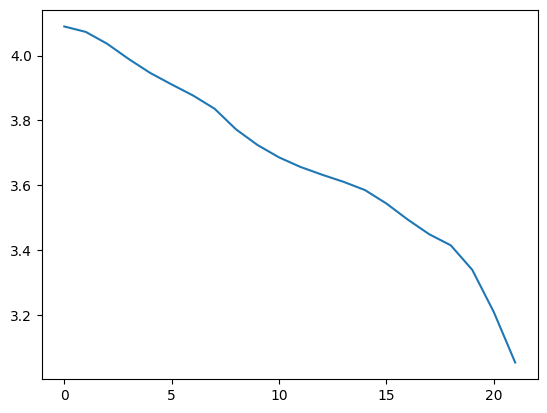

In [5]:
# Create a list to collect the first value from each DataFrame
first_values = [df['Voltage [V]'][0] for _, df in dfs.items()]
print(first_values)
plt.plot(first_values)

In [6]:
import numpy as np
np.gradient(first_values)

array([-0.0167 , -0.0267 , -0.0418 , -0.0449 , -0.0392 , -0.03485,
       -0.03745, -0.0522 , -0.05595, -0.04315, -0.0338 , -0.02665,
       -0.0229 , -0.0237 , -0.03345, -0.04565, -0.0475 , -0.0396 ,
       -0.05475, -0.1026 , -0.1429 , -0.1561 ])

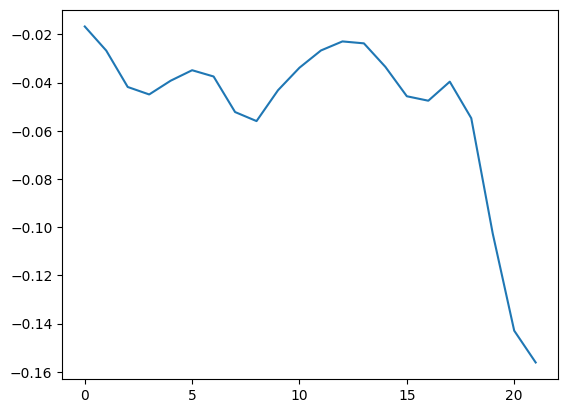

In [7]:
plt.plot(np.gradient(first_values))

We are creating a syntethic data first.

Synthethic data parameters are defined here:

Then, it is plotted:

The synthethic data is passed to a dataframe:

In [8]:
dfs['pulse_1.csv']["Time [s]"][0]

20194.53

In [9]:
d = {'Time [s]':(dfs['pulse_1.csv']["Time [s]"]-dfs['pulse_1.csv']["Time [s]"][0]), 
    'Voltage [V]': dfs['pulse_1.csv']["Voltage [V]"]}

data = pd.DataFrame(data = d)

In [10]:
data

,Time [s],Voltage [V]
0,0.00,4.0896
1,0.04,3.9507
2,0.78,3.9400
3,1.78,3.9344
4,2.78,3.9306
...,...,...
270,3491.02,4.0731
271,3551.02,4.0732
272,3611.02,4.0731
273,3671.02,4.0732


PbParam model to be used for GITT needs to be defined:

In [11]:
model = pbparam.BasicGITT()

Next, parameter dictionary needs to be defined with all of the required parameters:

In [20]:
param_dict=pybamm.ParameterValues({
        "Reference OCP [V]": 4.2,
        "Derivative of the OCP wrt stoichiometry [V]": -0.167,
        "Current function [A]": 0.680616,
        "Number of electrodes connected in parallel to make a cell": 1.0,
        "Electrode width [m]": 0.207,
        "Electrode height [m]": 0.137,
        "Positive electrode active material volume fraction": 0.5,
        "Positive particle radius [m]": 1e-05,
        "Positive electrode thickness [m]": 0.0001,
        "Positive electrode diffusivity [m2.s-1]": 5e-14,
        "Maximum concentration in positive electrode [mol.m-3]": 51217.9257309275,
        "Initial concentration in positive electrode [mol.m-3]": 1000,
        "Effective resistance [Ohm]": 0,
    })

In [21]:
# optimisation problem is GITT.
opt = pbparam.GITT(param_dict=param_dict,gitt_model=model, data=data)

Then, Optimisation method should be defined in this step. DiferentialEvolution(https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html) or ScipyMinimize(https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)

can be used to minimise cost function. For faster results, ScipyMinimize with ```"Nelder-Mead"``` method can be used. However, ScipyDifferentialEvolution is more robust and has provided lower value for most of the cases. 

In [22]:
# optimiser = pbparam.ScipyDifferentialEvolution(
#     extra_options={"workers": 4, "polish": True, "updating": "deferred", "disp": True}
# )
optimiser = pbparam.ScipyMinimize(method="Nelder-Mead")

After providing everything for optimisation algorithm, it can be performed using `optimise(optimisation_problem)`

In [23]:
result = optimiser.optimise(opt)
# optimised values of parameters and function values can be printed as below.
print(result)

KeyError: "'Negative electrode thickness [m]' not found. Best matches are ['Positive electrode thickness [m]', 'Positive electrode diffusivity [m2.s-1]', 'Electrode width [m]']"

```plot()``` function can be used to present result graphically.

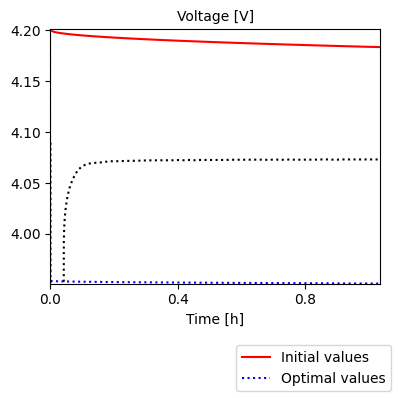

In [ ]:
result.plot()